In [ ]:
!pip install transformers datasets --quiet

In [ ]:
!pip install evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast
from transformers import BertForQuestionAnswering
from transformers import TrainingArguments
from transformers import DefaultDataCollator
import evaluate
from transformers import Trainer
import torch

1. Data Acquisition and Preprocessing

In [ ]:
# Dataset Selection and Loading:
# Load the SQuAD v1.1 dataset
dataset = load_dataset("squad")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


In [ ]:
# Data Exploration:
# View one sample
sample = dataset['train'][0]
print(f"Context:\n{sample['context']}\n")
print(f"Question:\n{sample['question']}\n")
print(f"Answer:\n{sample['answers']}\n")

Context:
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

Question:
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

Answer:
{'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}



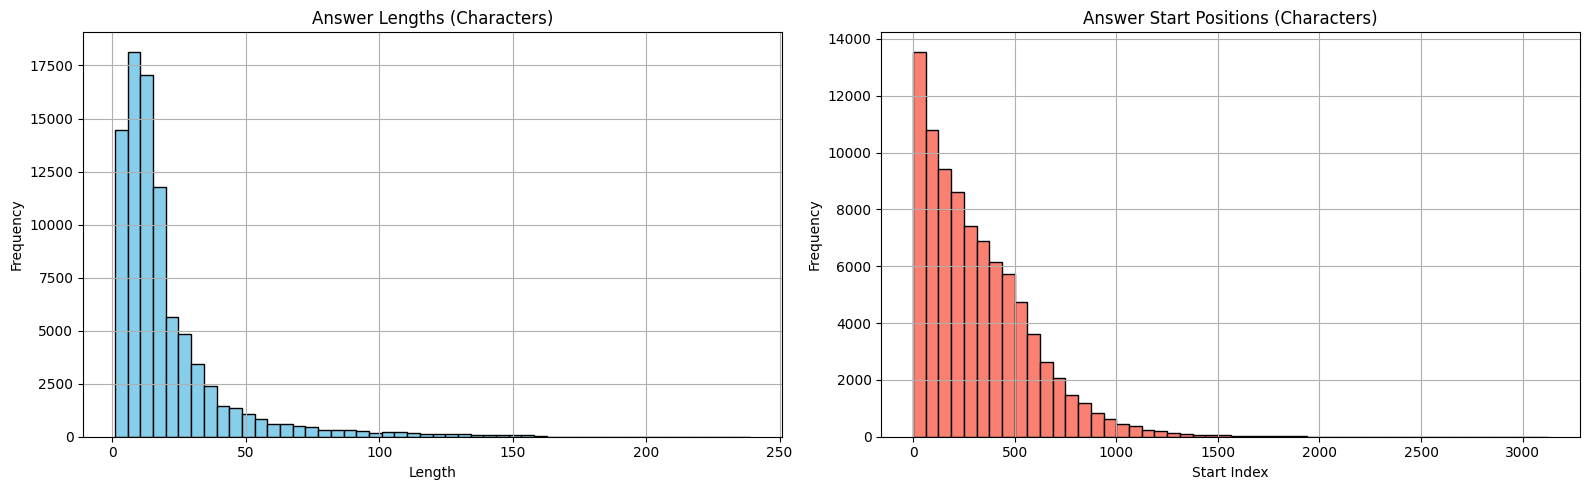

In [ ]:
# Visualize the distribution of answer lengths or positions:
# Extract answer lengths and start positions
answer_lengths = [len(answer['text'][0]) for answer in dataset['train']['answers']]
answer_starts = [answer['answer_start'][0] for answer in dataset['train']['answers']]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot answer lengths
axes[0].hist(answer_lengths, bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Answer Lengths (Characters)')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot answer start positions
axes[1].hist(answer_starts, bins=50, color='salmon', edgecolor='black')
axes[1].set_title('Answer Start Positions (Characters)')
axes[1].set_xlabel('Start Index')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Preprocessing:
# Tokenize the context passages and questions
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize with automatic truncation and padding
def preprocess(example):
    return tokenizer(
        example['question'],
        example['context'],
        truncation=True,
        padding='max_length',
        max_length=384,
        return_offsets_mapping=True
    )

tokenized_examples = dataset['train'].map(preprocess, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

In [ ]:
# Prepare inputs for the QA task:
def add_token_positions(example):
    tokenized_example = tokenizer(
        example["question"],
        example["context"],
        truncation=True,
        max_length=384,
        padding="max_length",
        return_offsets_mapping=True,
        return_token_type_ids=True,
    )

    # Character position of the answer
    start_char = example["answers"]["answer_start"][0]
    end_char = start_char + len(example["answers"]["text"][0])

    # Token type IDs: 0 for question, 1 for context
    token_type_ids = tokenized_example["token_type_ids"]
    offsets = tokenized_example["offset_mapping"]

    start_token = None
    end_token = None

    for idx, (start, end) in enumerate(offsets):
        if token_type_ids[idx] == 1:
            if start_token is None and start_char >= start and start_char < end:
                start_token = idx
            if end_char > start and end_char <= end:
                end_token = idx

    if start_token is None or end_token is None:
        start_token = 0
        end_token = 0

    tokenized_example["start_positions"] = start_token
    tokenized_example["end_positions"] = end_token

    return tokenized_example


In [ ]:
# Apply preprocessing
train_dataset = dataset["train"].map(add_token_positions)
val_dataset = dataset["validation"].map(add_token_positions)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

2. Model Selection and Fine-Tuning

In [ ]:
# Load the pre-trained model
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Fine-Tuning Setup:
training_args = TrainingArguments(
    output_dir="./results",           # Directory for saving model checkpoints
    eval_strategy="epoch",            # Evaluate at the end of each epoch (to match save_strategy)
    save_strategy="epoch",            # Save model at the end of each epoch
    per_device_train_batch_size=8,    # Reduce batch size to fit in memory
    per_device_eval_batch_size=8,     # Keep eval batch size consistent
    gradient_accumulation_steps=4,    # Accumulate gradients for a larger effective batch size
    fp16=True,                        # Enable mixed precision training
    optim="adamw_torch",              # Faster optimizer
    num_train_epochs=2,               # Reduce epochs to speed up training
    logging_dir="./logs",             # Directory for logs
    logging_steps=500,                # Log every 500 steps
    save_total_limit=2,               # Keep only the last 2 checkpoints
    load_best_model_at_end=True,      # Load the best model after training
    report_to="none",                 # Avoid logging to external tools (faster)
)

# Enable gradient checkpointing to save memory
model.gradient_checkpointing_enable()

In [ ]:
# Create a data collator to help batch the data during training (faster)
data_collator = DefaultDataCollator()

# Define which columns to use
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "token_type_ids", "start_positions", "end_positions"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "token_type_ids", "start_positions", "end_positions"])

3. Model Evaluation and Testing

In [ ]:
# # Load the SQuAD evaluation metric to assess the model's performance
squad_metric = evaluate.load("squad")

In [ ]:
# function to compare the model’s answers with ground truth answers and computes SQuAD scores (Exact Match & F1)
def compute_metrics(eval_pred):
    start_logits, end_logits = eval_pred.predictions
    start_positions, end_positions = eval_pred.label_ids  # unpack labels

    predictions = []
    references = []

    for i in range(len(start_logits)):
        input_ids = val_dataset[i]["input_ids"]

        # Find the predicted start and end positions
        start_pred = start_logits[i].argmax()
        end_pred = end_logits[i].argmax()

        # Ensure predictions are within valid range
        if start_pred > end_pred:
            pred_text = ""
        else:
            tokens = input_ids[start_pred:end_pred+1]
            pred_text = tokenizer.decode(tokens, skip_special_tokens=True)

        # Retrieve ground truth answer from the original dataset
        original_example = dataset["validation"][i]  # Fetch the original entry
        if "answers" in original_example and original_example["answers"]["text"]:
            ref_text = original_example["answers"]["text"][0]
        else:
            ref_text = ""  # If no valid answer exists

        predictions.append({"id": str(i), "prediction_text": pred_text})
        references.append({"id": str(i), "answers": {"answer_start": [0], "text": [ref_text]}})

    return squad_metric.compute(predictions=predictions, references=references)

In [ ]:
# Initialize the Hugging Face Trainer for fine-tuning the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

<ipython-input-27-83038aa1c980>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Exact Match,F1
1,0.438100,1.255328,57.275307,72.769217


TrainOutput(global_step=5474, training_loss=0.33357540377309214, metrics={'train_runtime': 4294.2652, 'train_samples_per_second': 40.798, 'train_steps_per_second': 1.275, 'total_flos': 3.432479117930035e+16, 'train_loss': 0.33357540377309214, 'epoch': 1.9994520547945207})

In [ ]:
# Run evaluation
results = trainer.evaluate()

# Print evaluation results
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 1.2553281784057617, 'eval_exact_match': 57.27530747398297, 'eval_f1': 72.76921664092971, 'eval_runtime': 65.0599, 'eval_samples_per_second': 162.466, 'eval_steps_per_second': 20.32, 'epoch': 1.9994520547945207}


Qualitative Testing:

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model.to(device)

def get_answer_from_model(model, tokenizer, question, context):
    # Tokenize input and move tensors to the same device
    inputs = tokenizer(question, context, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]

    with torch.no_grad():
        outputs = model(**inputs)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

    start_idx = torch.argmax(start_logits)
    end_idx = torch.argmax(end_logits) + 1

    answer_ids = input_ids[0][start_idx:end_idx]
    answer = tokenizer.decode(answer_ids, skip_special_tokens=True)
    return answer


# Example test samples
samples = [
    {
        "context": "The Eiffel Tower is located in Paris. It was built in 1889 and is one of the most famous landmarks in the world.",
        "question": "Where is the Eiffel Tower located?",
        "ground_truth": "Paris"
    },
    {
        "context": "The Amazon River flows through South America and is the second longest river in the world.",
        "question": "What continent does the Amazon River flow through?",
        "ground_truth": "South America"
    },
]

In [ ]:
# Run the model and compare predictions
for i, sample in enumerate(samples):
    predicted = get_answer_from_model(model, tokenizer, sample["question"], sample["context"])
    print(f"--- Sample {i+1} ---")
    print(f"Question     : {sample['question']}")
    print(f"Context      : {sample['context']}")
    print(f"Ground Truth : {sample['ground_truth']}")
    print(f"Prediction   : {predicted}")
    print(f"Correct" if predicted.lower() in sample["ground_truth"].lower() else f"Incorrect")
    print()

--- Sample 1 ---
Question     : Where is the Eiffel Tower located?
Context      : The Eiffel Tower is located in Paris. It was built in 1889 and is one of the most famous landmarks in the world.
Ground Truth : Paris
Prediction   : paris
Correct

--- Sample 2 ---
Question     : What continent does the Amazon River flow through?
Context      : The Amazon River flows through South America and is the second longest river in the world.
Ground Truth : South America
Prediction   : south america
Correct



In [ ]:
# Save the fine-tuned model and tokenizer to directory "qa_model"
model.save_pretrained("qa_model")
tokenizer.save_pretrained("qa_model")

('qa_model/tokenizer_config.json',
 'qa_model/special_tokens_map.json',
 'qa_model/vocab.txt',
 'qa_model/added_tokens.json',
 'qa_model/tokenizer.json')

In [ ]:
# Download the model as zip file
from google.colab import files
import shutil
shutil.make_archive("qa_model", 'zip', "qa_model")
files.download("qa_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>